In [6]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules created for this project
import project_modules.calibrate_camera as cc
import project_modules.image_process as ip
import project_modules.find_lanes as fl
import project_modules.process_video as pv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Misc functions

def get_test_image_names():
    images = glob.glob('test_images/*.jpg')
    return images

def display_images(img):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img)

    

In [8]:
# Image procss pipeline for actual iamge
def image_process_pipeline(img, imgpoints, objpoints):
    img = ip.undistort_image(img, imgpoints, objpoints)
    img = ip.color_threshold(img)
    img, Minv = ip.perspective_transform(img)    
    return img, Minv

# Function to pass into video processing
def process_image(img, imgpoints, objpoints):
    processed_img, Minv = image_process_pipeline(img, imgpoints, objpoints) # Process each image frame
    
    # Find the lanes and radius of curvature & car position in each image
    out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = fl.find_lanes(processed_img)
    left_curverad, right_curverad, left_fitx, right_fitx = fl.curvature_measurement(out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
    car_position = fl.vehicle_position(out_img, left_fit, right_fit)
    
    # Apply smoothing filter in case some fits are outliers.
    left_fitx = fl.line_smoothing(left_line, left_fitx, left_curverad)
    right_fitx = fl.line_smoothing(right_line, right_fitx, right_curverad)
    left_line.curve_list.append(left_curverad)  # For smoothing the curve output in image overlay
   
    # Draw found lane onto image
    result = pv.draw_lane_image(img, processed_img, left_fitx, right_fitx, Minv)
    result = pv.output_curvature_data(result,left_curverad,car_position, left_line)
    
    return result

In [9]:
image_names = cc.get_calibration_image_names()
imgpoints, objpoints = cc.calibrate_camera(image_names)

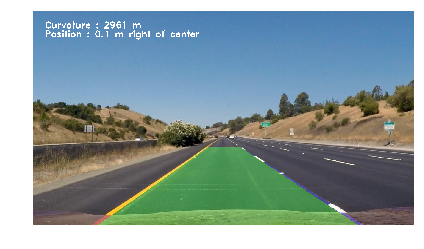

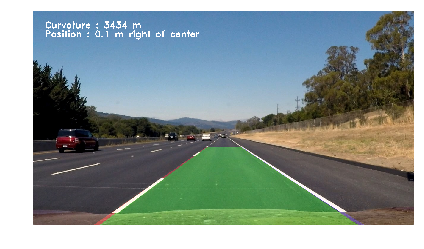

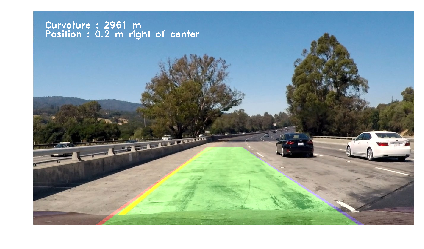

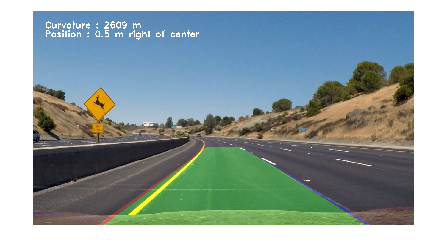

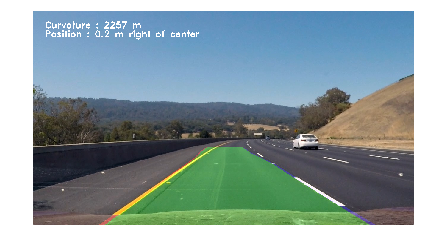

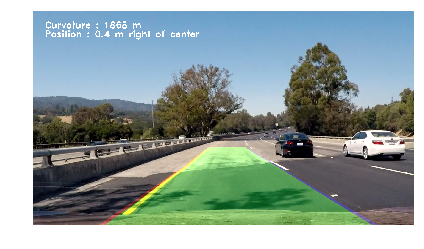

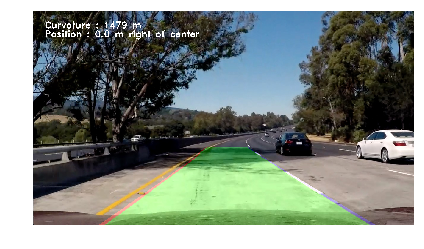

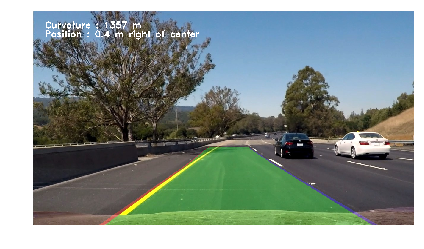

In [15]:
# Create left and right line objects
left_line = fl.Line()
right_line = fl.Line()

# Test full image process pipeline on test images
test_images = get_test_image_names()

for image in test_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processed_img = process_image(img, imgpoints, objpoints)
    display_images(processed_img)
    processed_filename = 'output_images/lane_overlay_processed_' + os.path.basename(image)       
    mpimg.imsave(processed_filename, processed_img)
    